## Кириллов Д.С. ИУ5-22М

Вариант 7

- 1 класс = номер группы + 15 = 22 + 15 = 37 (дома, house)
- 2 класс = номер варианта + 56 = 7 + 56 = 63 (дикобразы, porcupine)
- 3 класс = номер варианта + 21 = 7 + 21 = 28 (чашки, cup)

Предобученная модель по варианту - mobilenetv2_x0_5

In [136]:
# !wget https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz
# !tar -xvzf cifar-100-python.tar.gz

# !rm cifar-100-python.tar.gz*
# !mkdir data
# !mv cifar* data/

# !mkdir -p models/lab4

In [137]:
!pip install torchsummary

In [138]:
import time
from datetime import datetime
import numpy as np
import os

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, Dataset, DataLoader
from torchsummary import summary
from torchvision import transforms as T

import pickle
from sklearn.metrics import classification_report
from PIL import Image
from tqdm.auto import tqdm
from IPython.display import clear_output
import matplotlib.pyplot as plt

import tensorflow
from tensorflow import summary as tfsummary

%matplotlib inline

In [139]:
!nvidia-smi

Sun Mar 31 12:33:49 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla P100-PCIE-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P0              36W / 250W |  15786MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [140]:
tensorflow.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [141]:
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
device

device(type='cuda')

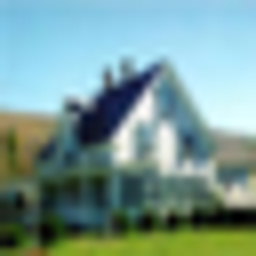

In [142]:
with open('data/cifar-100-python/train', 'rb') as f:
    data_train = pickle.load(f, encoding='latin1')
with open('data/cifar-100-python/test', 'rb') as f:
    data_test = pickle.load(f, encoding='latin1')

# Здесь указать ваши классы по варианту!!!
CLASSES = [37, 63, 28]

train_X = data_train['data'].reshape(-1, 3, 32, 32)
train_X = np.transpose(train_X, [0, 2, 3, 1]) # NCHW -> NHWC
train_y = np.array(data_train['fine_labels'])
mask = np.isin(train_y, CLASSES)
train_X = train_X[mask].copy()
train_y = train_y[mask].copy()
train_y = np.unique(train_y, return_inverse=1)[1]
del data_train

test_X = data_test['data'].reshape(-1, 3, 32, 32)
test_X = np.transpose(test_X, [0, 2, 3, 1])
test_y = np.array(data_test['fine_labels'])
mask = np.isin(test_y, CLASSES)
test_X = test_X[mask].copy()
test_y = test_y[mask].copy()
test_y = np.unique(test_y, return_inverse=1)[1]
del data_test
Image.fromarray(train_X[50]).resize((256,256))

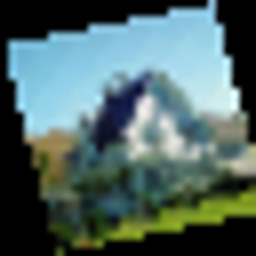

In [143]:
class CifarDataset(Dataset):
     def __init__(self, X, y, transform=None, p=0.0):
         assert X.size(0) == y.size(0)
         super(Dataset, self).__init__()
         self.X = X
         self.y = y
         self.transform = transform
         self.prob = p
        
     def __len__(self):
         return self.y.size(0)
        
     def __getitem__(self, index):
        x = self.X[index]
        if self.transform and np.random.random()<self.prob:
            x = self.transform(x.permute(2, 0, 1)/255.).permute(1, 2, 0)*255.
        y = self.y[index]
        return x, y

# Параметры аугментации, которые позволили мне обучить наилучшую модель в ЛР-3. Совпадают с параметрами по умолчанию в коде ЛР-3, ЛР-4.
transform = T.Compose([
    T.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.2, hue=0.0),
    T.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.8, 1.2), shear=5),
])

Image.fromarray((transform(torch.Tensor(train_X[50]).permute(2, 0, 1)/255.).\
                 permute(1, 2, 0).numpy()*255.).astype(np.uint8)).\
                 resize((256, 256))

# Гиперпараметры и параметры

In [144]:
# Исправлен код Ишкова. Гиперпараметры вынесены сюда.


# HIDDEN_SIZE = 64 # не используется. Мы загружаем предобученную модель


PRETRAINED=True
PRETRAINED_MODEL_NAME = "cifar100_mobilenetv2_x0_5" # - нечетные / cifar100_resnet20' - четные


batch_size = 128 # по умолчанию

# LR=3e-4 # по умолчанию
LR=3e-3 # 


# EPOCHS = 60 # по умолчанию
EPOCHS = 31 # Оптимум для п.4

# Создание Pytorch DataLoader'a

In [145]:
dataloader = {}
for (X, y), part in zip([(train_X, train_y), (test_X, test_y)],
                        ['train', 'test']):
    tensor_x = torch.Tensor(X)
    tensor_y = F.one_hot(torch.Tensor(y).to(torch.int64),
                                     num_classes=len(CLASSES))/1.
    dataset = CifarDataset(tensor_x, tensor_y,
                           transform if part=='train' else None,
                           p=0.5) # создание объекта датасета
    dataloader[part] = DataLoader(dataset, batch_size=batch_size,
                                  prefetch_factor=8 if part=='train' else 2,
                                  num_workers=2,
                                  persistent_workers=True,
                                  shuffle=True) # создание экземпляра класса DataLoader
dataloader

{'train': <torch.utils.data.dataloader.DataLoader at 0x7e88b834f370>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x7e88b834cf40>}

# Инициализация модели

Переменная `model` - это загруженная с PyTorch Hub предобученная на CIFAR-100 модель. `new_model` - это model с одним добавленным в начало слоем `Normalize`. Т.е. считаем, что `model` и `new_model` - это предобученные модели.


Далее есть 4 вывода `summary(new_model, input_size=(size, size, num_channels))`. Пометил комментариями "Вывод №1/2/3/4".

> Цифры по количеству параметров приведены для модели `cifar100_mobilenetv2_x0_5`.

**Первый** выводит архитектуру new_model.
- Предобученная модель обучалась на датасете 32х32 х3 цвета, 100 классов
- Входной слой - Normalize-1 [-1, 3, 32, 32] 0
- Выходной слой - Linear-159 [-1, 100] 128,100
- Total params: 815,780
- Trainable params: 815,780
- Non-trainable params: 0

**Второй** выводит архитектуру new_model, настроенную под прием изображений 512х512 х3 цвета: `input_size=(3, 512, 512)))`.
- Эта модель может принимать картинки 512х512 х3 цвета и различает 100 классов
- Входной слой - Normalize-1 [-1, 3, 512, 512] 0
- Выходной слой - Linear-158 [-1, 100] 128,100
- Total params: 815,780
- Trainable params: 815,780
- Non-trainable params: 0

**Третий** выводит архитектуру new_model, настроенную под прием изображений 32х32 х3 цвета, которая теперь будет различать 3 класса. Ее мы и будем дообучать через Fine Tunning. Как бы подгоняем модель new_model по размерам под свой датасет.
- У двух предыдущих моделей последний слой был Linear-159 [-1, 100] 128,100
- Входной слой - Normalize-1 [-1, 3, 32, 32] 0
- Выходной слой стал Linear-159 [-1, 3] 3,843
- Total params: 691,523
- Trainable params: 691,523
- Non-trainable params: 0

**Четвертый** выводит `new_model` с измененными флагами `param.requires_grad` (это заморозка весов)
- Слои как в выводе №3. По сравнению с выводом №3 поменялись Trainable params и Non-trainable params
- Total params: 691,523
- Trainable params: 3,843
- Non-trainable params: 687,680


In [146]:
# Исправлен код Ишкова. Своя архитектура модели не нужна.
# Наверх вынесены параметры PRETRAINED_MODEL_NAME, PRETRAINED

class Normalize(nn.Module):
    def __init__(self, mean, std):
        super(Normalize, self).__init__()
        self.mean = torch.tensor(mean).to(device)
        self.std = torch.tensor(std).to(device)

    def forward(self, input):
        x = input / 255.0
        x = x - self.mean
        x = x / self.std
        return x.permute(0, 3, 1, 2) # nhwc -> nm

class GlobalMaxPool2d(nn.Module):
    def __init__(self):
        super(GlobalMaxPool2d, self).__init__()

    def forward(self, input):
        out = F.adaptive_max_pool2d(input, output_size=1)
        return out.flatten(start_dim=1)


model = torch.hub.load("chenyaofo/pytorch-cifar-models",
                       PRETRAINED_MODEL_NAME,
                       pretrained=PRETRAINED)
model.to(device)
new_model = nn.Sequential(
    Normalize([0.5074,0.4867,0.4411],[0.2011,0.1987,0.2025]),# https://blog.jovian.ai/image-classification-of-cifar100-dataset-using-pytorch-8b7145242df1
    model
).to(device)

# Вывод №1 new_model
print(new_model(torch.rand(1, 32, 32, 3).to(device)))
print(summary(new_model, input_size=(32, 32, 3)))
print(new_model)

tensor([[-4.6401e-01, -4.4323e-01,  3.2999e-01, -1.0419e-01,  1.8977e-03,
         -6.9001e-01, -7.1355e-02,  1.3031e-01,  1.6071e-01,  6.9174e-01,
          4.1965e-01,  8.5989e-01, -5.6687e-01, -1.0628e-01, -3.4749e-01,
          8.8828e-01, -3.8846e-01, -4.0763e-01,  3.3954e-01,  8.3490e-01,
         -4.0652e-01,  6.5274e-01,  4.3219e-01, -4.8463e-01, -2.9337e-01,
          2.3260e-01,  4.7519e-01, -3.8320e-01, -4.0978e-01,  1.4573e+00,
         -6.1303e-01,  2.2869e-02,  7.0146e-01,  7.5755e-01, -3.9256e-01,
         -1.3889e-01,  1.2034e-01,  4.5718e-02,  8.3770e-02,  9.8165e-02,
          7.5848e-01, -1.1047e-01,  7.0471e-01, -2.2326e-01,  7.5783e-01,
          1.0871e+00,  5.8807e-01, -1.3574e+00, -5.6119e-01, -5.2117e-01,
          5.7370e-01,  6.3275e-01, -1.5757e+00, -4.6762e-01, -2.2179e-01,
          8.1154e-01, -2.4842e-02,  7.3422e-01, -8.5212e-01,  1.6875e-01,
         -6.9694e-01, -1.9979e-01, -6.8525e-02,  2.3337e-01,  7.7907e-01,
          8.9896e-01,  2.6651e-01,  8.

Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


In [147]:
# Вывод №2 model для сравнения.
# Почему 512х512? Просто демонстрация настройки под свой датасет
# почему 3х512 х512 цветов? вот это не понятно

print(summary(model, input_size=(3, 512, 512)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 512, 512]             432
       BatchNorm2d-2         [-1, 16, 512, 512]              32
             ReLU6-3         [-1, 16, 512, 512]               0
            Conv2d-4         [-1, 16, 512, 512]             144
       BatchNorm2d-5         [-1, 16, 512, 512]              32
             ReLU6-6         [-1, 16, 512, 512]               0
            Conv2d-7          [-1, 8, 512, 512]             128
       BatchNorm2d-8          [-1, 8, 512, 512]              16
  InvertedResidual-9          [-1, 8, 512, 512]               0
           Conv2d-10         [-1, 48, 512, 512]             384
      BatchNorm2d-11         [-1, 48, 512, 512]              96
            ReLU6-12         [-1, 48, 512, 512]               0
           Conv2d-13         [-1, 48, 512, 512]             432
      BatchNorm2d-14         [-1, 48, 5

In [148]:
# Эта штука считает размер рецептивного поля сети model.
# Receptive field of a convolutional network - Рецептивное поле сети - https://theaisummer.com/receptive-field/
# Neuron’s receptive field - Рецептивное поле нейрона - это вроде то же, что размер ядра свёртки.
# https://github.com/Fangyh09/pytorch-receptive-field.git
def compute_RF_numerical(net,img_np):
    '''
    @param net: Pytorch network
    @param img_np: numpy array to use as input to the networks, it must be full of ones and with the correct
    shape.
    '''
    def weights_init(m):
        classname = m.__class__.__name__
        if classname.find('Conv') != -1:
            m.weight.data.fill_(1)
            m.bias.data.fill_(0)
    #net.apply(weights_init)
    img_ = torch.tensor(torch.from_numpy(img_np).float(),requires_grad=True)
    out_cnn=net(img_.to(device))
    out_shape=out_cnn.size()
    ndims=len(out_cnn.size())
    grad=torch.zeros(out_cnn.size())
    l_tmp=[]
    for i in range(ndims):
        if i==0 or i ==1:#batch or channel
            l_tmp.append(0)
        else:
            l_tmp.append(out_shape[i]/2)
            
    grad[tuple(l_tmp)]=1
    out_cnn.backward(gradient=grad.to(device))
    grad_np=img_.grad[0,0].data.detach().cpu().numpy()
    idx_nonzeros=np.where(grad_np!=0)
    RF=[np.max(idx)-np.min(idx)+1 for idx in idx_nonzeros]
    
    return RF

print(compute_RF_numerical(model, np.zeros((1, 3, 1024, 1024))))

# Какая-то хрень. Очень важны размеры картинки
# print(compute_RF_numerical(new_model, np.zeros((1, 128, 128, 3))))

/tmp/ipykernel_34/2048221701.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img_ = torch.tensor(torch.from_numpy(img_np).float(),requires_grad=True)


[1024, 1024]


In [149]:
# Подгоняем модель по размерам под свой датасет.
# У них было 100 классов картинок 32х32 х3 цвета.
# У нас 3 класса картинок 32х32 х3 цвета.

print(PRETRAINED_MODEL_NAME)

# mobilenetv2
if PRETRAINED_MODEL_NAME == "cifar100_mobilenetv2_x0_5":
    in_features = new_model[1].classifier[1].in_features
    new_model[1].classifier[1] = nn.Linear(in_features=in_features,
                                      out_features=len(CLASSES),
                                      bias=True)

## resnet20
if PRETRAINED_MODEL_NAME == "cifar100_resnet20":
    in_features = new_model[1].fc.in_features
    new_model[1].fc = nn.Linear(in_features=in_features,
                            out_features=len(CLASSES),
                            bias=True)
    
# Вывод №3 new_model с измененными in_features
new_model.to(device)
print(summary(new_model, input_size=(32, 32, 3)))
print(new_model(torch.rand(1, 32, 32, 3).to(device)))

cifar100_mobilenetv2_x0_5
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         Normalize-1            [-1, 3, 32, 32]               0
            Conv2d-2           [-1, 16, 32, 32]             432
       BatchNorm2d-3           [-1, 16, 32, 32]              32
             ReLU6-4           [-1, 16, 32, 32]               0
            Conv2d-5           [-1, 16, 32, 32]             144
       BatchNorm2d-6           [-1, 16, 32, 32]              32
             ReLU6-7           [-1, 16, 32, 32]               0
            Conv2d-8            [-1, 8, 32, 32]             128
       BatchNorm2d-9            [-1, 8, 32, 32]              16
 InvertedResidual-10            [-1, 8, 32, 32]               0
           Conv2d-11           [-1, 48, 32, 32]             384
      BatchNorm2d-12           [-1, 48, 32, 32]              96
            ReLU6-13           [-1, 48, 32, 32]               0
           Co

# Заморозка весов

In [150]:
# keep_last = 2 # по умолчанию
keep_last = len([*new_model.named_parameters()]) # равно без заморозки весов

total = len([*new_model.named_parameters()])
params_to_update = []
print("Обучаемые параметры:")
for i, (name, param) in enumerate(new_model.named_parameters()):
    if i < total - keep_last:
        param.requires_grad = False 
    else:
        params_to_update.append(param)
        param.requires_grad = True
        print("\t",name)
        
# # Вывод 4. new_model с измененными флагами param.requires_grad
# # По сравнению с выводом №3 поменялись Trainable params и Non-trainable params
# summary(new_model, input_size=(32, 32, 3))

Обучаемые параметры:
	 1.features.0.0.weight
	 1.features.0.1.weight
	 1.features.0.1.bias
	 1.features.1.conv.0.0.weight
	 1.features.1.conv.0.1.weight
	 1.features.1.conv.0.1.bias
	 1.features.1.conv.1.weight
	 1.features.1.conv.2.weight
	 1.features.1.conv.2.bias
	 1.features.2.conv.0.0.weight
	 1.features.2.conv.0.1.weight
	 1.features.2.conv.0.1.bias
	 1.features.2.conv.1.0.weight
	 1.features.2.conv.1.1.weight
	 1.features.2.conv.1.1.bias
	 1.features.2.conv.2.weight
	 1.features.2.conv.3.weight
	 1.features.2.conv.3.bias
	 1.features.3.conv.0.0.weight
	 1.features.3.conv.0.1.weight
	 1.features.3.conv.0.1.bias
	 1.features.3.conv.1.0.weight
	 1.features.3.conv.1.1.weight
	 1.features.3.conv.1.1.bias
	 1.features.3.conv.2.weight
	 1.features.3.conv.3.weight
	 1.features.3.conv.3.bias
	 1.features.4.conv.0.0.weight
	 1.features.4.conv.0.1.weight
	 1.features.4.conv.0.1.bias
	 1.features.4.conv.1.0.weight
	 1.features.4.conv.1.1.weight
	 1.features.4.conv.1.1.bias
	 1.features.4.co

# Tensorboard

Tensorboard в этой лабе не просят.

Tensorboard Extension не работает в ноутбуках Kaggle

In [151]:
# Общее имя для модели, логов в TensorBoard, архива с логами
MODEL_NAME = datetime.now().strftime("%d.%m-%H:%M:%S")  # даты будут -3 часа, т.к. часовой пояс на сервере Kaggle - UTC +0
os.environ["MODEL_NAME"] = MODEL_NAME # буду использовать для названия zip-архива в unix-команде
MODEL_NAME

'31.03-12:33:51'

In [152]:
train_log_dir = 'logs/tensorboard-lab4/train/' + MODEL_NAME
test_log_dir = 'logs/tensorboard-lab4/test/' + MODEL_NAME
train_summary_writer = tfsummary.create_file_writer(train_log_dir)
test_summary_writer = tfsummary.create_file_writer(test_log_dir)

# Обучение, Fine tunning

In [153]:
# Исправлен код Ишкова. Сделал lr отдельной переменной. Гиперпараметр LR вынесен наверх.

# добавляем сглаживание целевых меток, это увеличит значение функции потерь
# но полученная модель будет более устойчивой к выбросам в обучающей выборке
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
# используется SGD c momentum и L2-регуляризацией весов
optimizer = optim.SGD(params_to_update, lr=LR, momentum=0.9,
                      weight_decay=1e-5)
# добавляем постепенное уменьшение шага обучения каждые 20 эпох
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)

31.03-12:33:51
Лучшая доля правильных ответов: 99.21875 на 4 эпохе
Текущая доля правильных ответов: 98.72159067789714 (эпоха 31)


  0%|          | 0/372 [00:00<?, ?it/s]

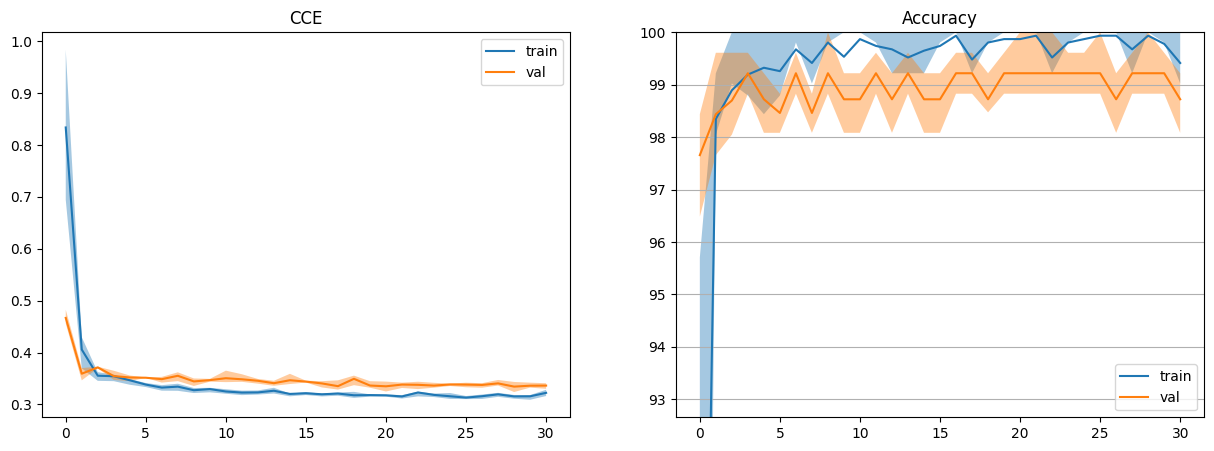

Обучение закончено за 185.28119373321533 секунд


In [154]:
# Исправлен код Ишкова.
# - Гиперпараметр EPOCHS вынесен наверх.
# - REDRAW_EVERY - больше не константа.
# - Вывод номера эпохи
# - запись в tensorboard как в ЛР-3

REDRAW_EVERY = max(int(EPOCHS / 25), 1)
steps_per_epoch = len(dataloader['train'])
steps_per_epoch_val = len(dataloader['test'])

pbar = tqdm(total=EPOCHS*steps_per_epoch)
losses = []
losses_val = []
passed = 0
# для создания чекпоинта
best_acc = 0
best_epoch_i = None
checkpoint_path = 'cifar_cnn_fine.pth' 

for epoch in range(EPOCHS):  # проход по набору данных несколько раз
    tmp = []
    new_model.train()
    for i, batch in enumerate(dataloader['train'], 0):
        # получение одного минибатча; batch это двуэлементный список из [inputs, labels]
        inputs, labels = batch
        # на GPU
        inputs, labels = inputs.to(device), labels.to(device)

        # очищение прошлых градиентов с прошлой итерации
        optimizer.zero_grad()

        # прямой + обратный проходы + оптимизация
        outputs = new_model(inputs)
        loss = criterion(outputs, labels)
        #loss = F.cross_entropy(outputs, labels)
        loss.backward()
        optimizer.step()

        # для подсчёта статистик
        accuracy = (labels.detach().argmax(dim=-1)==outputs.detach().argmax(dim=-1)).\
                    to(torch.float32).mean().cpu()*100
        tmp.append((loss.item(), accuracy.item()))
        pbar.update(1)
        
        # запись в tensorboard
        with train_summary_writer.as_default():
            tfsummary.scalar('loss', tmp[-1][0], step=pbar.n)
            tfsummary.scalar('accuracy', tmp[-1][1], step=pbar.n)
        
    losses.append((np.mean(tmp, axis=0),
                   np.percentile(tmp, 25, axis=0),
                   np.percentile(tmp, 75, axis=0)))
    scheduler.step() # обновляем learning_rate каждую эпоху
    tmp = []
    new_model.eval()
    with torch.no_grad(): # отключение автоматического дифференцирования
        for i, data in enumerate(dataloader['test'], 0):
            inputs, labels = data
            # на GPU
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = new_model(inputs)
            loss = criterion(outputs, labels)
            accuracy = (labels.argmax(dim=-1)==outputs.argmax(dim=-1)).\
                        to(torch.float32).mean().cpu()*100
            tmp.append((loss.item(), accuracy.item()))
    losses_val.append((np.mean(tmp, axis=0),
                       np.percentile(tmp, 25, axis=0),
                       np.percentile(tmp, 75, axis=0)))
    # запись в tensorboard
    with test_summary_writer.as_default():
        tfsummary.scalar('loss', losses_val[-1][0][0], step=pbar.n)
        tfsummary.scalar('accuracy', losses_val[-1][0][1], step=pbar.n)
    
    # сохранение чекпоинта
    acc = losses_val[-1][0][1]
    if acc > best_acc:
        best_acc = acc
        best_epoch_i = epoch
        torch.save(new_model.state_dict(), checkpoint_path)

    # обновление графиков
    if (epoch+1) % REDRAW_EVERY != 0:
        continue
    clear_output(wait=False)
    
    print(MODEL_NAME)
    print('Лучшая доля правильных ответов: %s на %s эпохе\n'
          'Текущая доля правильных ответов: %s (эпоха %s)' % (best_acc, best_epoch_i+1, acc, epoch+1))
    
    passed += pbar.format_dict['elapsed']
    pbar = tqdm(total=EPOCHS*steps_per_epoch, miniters=5)
    pbar.update((epoch+1)*steps_per_epoch)
    x_vals = np.arange(epoch+1)
    _, ax = plt.subplots(1, 2, figsize=(15, 5))
    stats = np.array(losses)
    stats_val = np.array(losses_val)
    ax[1].set_ylim(stats_val[:, 0, 1].min()-5, 100)
    ax[1].grid(axis='y')
    for i, title in enumerate(['CCE', 'Accuracy']):
        ax[i].plot(x_vals, stats[:, 0, i], label='train')
        ax[i].fill_between(x_vals, stats[:, 1, i],
                           stats[:, 2, i], alpha=0.4)
        ax[i].plot(x_vals, stats_val[:, 0, i], label='val')
        ax[i].fill_between(x_vals,
                           stats_val[:, 1, i],
                           stats_val[:, 2, i], alpha=0.4)
        ax[i].legend()
        ax[i].set_title(title)
    plt.show()

new_model.load_state_dict(torch.load(checkpoint_path))
print('Обучение закончено за %s секунд' % passed)

# Просмотр TensorBoard не в Kaggle

Скачиваю архив с логами, чтобы посмотреть локально.

На панели справа ЛКМ по "обновить папку kaggle/working/" > листаем до файла .zip > три точки > Download.

In [155]:
!zip -r "logs/tensorboard-logs-$MODEL_NAME.zip" logs/tensorboard-lab4 > /dev/null 2>&1

# Проверка качества модели

по сравнению с кодом ЛР поменялось только название переменной с моделью model -> new_model

In [156]:
# Исправлен код Ишкова. Константа batch_size дублируется.
# batch_size = 128

dataloader = {}
for (X, y), part in zip([(train_X, train_y), (test_X, test_y)],
                        ['train', 'test']):
    tensor_x = torch.Tensor(X)
    tensor_y = F.one_hot(torch.Tensor(y).to(torch.int64),
                                     num_classes=len(CLASSES))/1.
    dataset = CifarDataset(tensor_x, tensor_y,
                           transform=None,
                           p=0.0) # создание объекта датасета
    dataloader[part] = DataLoader(dataset, batch_size=batch_size,
                                  num_workers=2, shuffle=True) # создание экземпляра класса DataLoader
dataloader

{'train': <torch.utils.data.dataloader.DataLoader at 0x7e83f446d6f0>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x7e83f4522590>}

In [157]:
print(MODEL_NAME)

for part in ['train', 'test']:
    y_pred = []
    y_true = []
    with torch.no_grad(): # отключение автоматического дифференцирования
        for i, data in enumerate(dataloader[part], 0):
            inputs, labels = data
             # на GPU
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = new_model(inputs).detach().cpu().numpy()
            y_pred.append(outputs)
            y_true.append(labels.cpu().numpy())
        y_true = np.concatenate(y_true)
        y_pred = np.concatenate(y_pred)
        print(part)
        print(classification_report(y_true.argmax(axis=-1), y_pred.argmax(axis=-1),
                                    digits=4, target_names=list(map(str, CLASSES))))
        print('-'*50)

31.03-12:33:51
train
              precision    recall  f1-score   support

          37     1.0000    1.0000    1.0000       500
          63     1.0000    1.0000    1.0000       500
          28     1.0000    1.0000    1.0000       500

    accuracy                         1.0000      1500
   macro avg     1.0000    1.0000    1.0000      1500
weighted avg     1.0000    1.0000    1.0000      1500

--------------------------------------------------
test
              precision    recall  f1-score   support

          37     1.0000    0.9900    0.9950       100
          63     0.9709    1.0000    0.9852       100
          28     1.0000    0.9800    0.9899       100

    accuracy                         0.9900       300
   macro avg     0.9903    0.9900    0.9900       300
weighted avg     0.9903    0.9900    0.9900       300

--------------------------------------------------


# Сохранение модели и архитектуры

In [158]:
# !mkdir -p models/lab4

In [159]:
torch.save(model, "models/lab4/cifar100_CNN_AUG-" + MODEL_NAME + ".pt")

Скачать все обученные модели.

In [164]:
!zip -r "models/models-lab4-$MODEL_NAME.zip" models/lab4 > /dev/null 2>&1

Пример загрузки и вывода параметров

```python
# загрузка
new_model = torch.load("models/lab4/cifar100_CNN_AUG-" + '17.03-15:48:43' + ".pt")
new_model.eval()

for part in ['train', 'test']:
    y_pred = []
    y_true = []
    with torch.no_grad(): # отключение автоматического дифференцирования
        for i, data in enumerate(dataloader[part], 0):
            inputs, labels = data
             # на GPU
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = new_model(inputs).detach().cpu().numpy()
            y_pred.append(outputs)
            y_true.append(labels.cpu().numpy())
        y_true = np.concatenate(y_true)
        y_pred = np.concatenate(y_pred)
        print(part)
        print(classification_report(y_true.argmax(axis=-1), y_pred.argmax(axis=-1),
                                    digits=4, target_names=list(map(str, CLASSES))))
        print('-'*50)
```


# Сохранение модели в ONNX


In [161]:
# Ишков забыл переименовать переменную model -> new_model и экспортирует не то
# Ячейка с class MyModel вроде не нужна

# # входной тензор для модели
# x = torch.randn(1, 32, 32, 3, requires_grad=True).to(device)
# torch_out = new_model(x)

# # экспорт модели
# torch.onnx.export(new_model,           # модель
#                   x,                   # входной тензор (или кортеж нескольких тензоров)
#                   "models/lab4/cifar100_CNN_AUG-" + datetime.now().strftime("%d.%m-%H:%M:%S") + ".onnx", # куда сохранить (либо путь к файлу либо fileObject)
#                   export_params=True,  # сохраняет веса обученных параметров внутри файла модели
#                   opset_version=9,     # версия ONNX
#                   do_constant_folding=True,  # следует ли выполнять укорачивание констант для оптимизации
#                   input_names = ['input'],   # имя входного слоя
#                   output_names = ['output'],  # имя выходного слоя
#                   dynamic_axes={'input' : {0 : 'batch_size'},    # динамичные оси, в данном случае только размер пакета
#                                 'output' : {0 : 'batch_size'}})